# Sentiment Analysis Kampus Merdeka
[Sumber Data : https://github.com/farahdhaifa/kampus-merdeka-crossvalidation](https://github.com/farahdhaifa/kampus-merdeka-crossvalidation)

**Instalasi Package**

Melalui terminal / bash, jalankan perintah berikut:

``` bash
pip3 install -r requirements.txt
```

# Import Section

In [1]:
import numpy as np
from numpy import mean
import pandas as pd
import matplotlib.pyplot as plt
import re  
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bestlabmct/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bestlabmct/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
MYRANDOMSTATE = 42

# 1. Tahap Preparation
##### 1.1 Read Dataset

In [3]:
comm = pd.read_csv('data_komentar_dl900.csv')
comm = comm.iloc[:,[1,0]]
comm.rename(columns={'KOMENTAR' : '0_KOMENTAR_ASLI'}, inplace=True)
comm.head()

,SENTIMEN,0_KOMENTAR_ASLI
0,1,Bagus. Salah satu pendekatan antropologi diken...
1,1,"Terimakasih, saya dapat informasi yg sangat be..."
2,1,Terima kasih mahasiswa perwakilan dari Indones...
3,1,"bagus mas menteri, saya bangga"
4,1,ide sangat cemerlang n patut didukung oleh sem...


In [4]:
comm['SENTIMEN'].value_counts()

1    500
0    500
Name: SENTIMEN, dtype: int64

##### 1.2 Cleaning Dataset

In [5]:
def textclean(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #remove @mentions
    text = re.sub(r'#', '', text) #remove # symbol
    text = re.sub(r'RT[\s]+', '', text) #remove RT
    text = re.sub(r'https?:\/\/\S+', '', text) #remove hyperlink
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #remove punctuation
    text = re.sub(r'\d+', '', text) #remove number
    text = text.strip() #remove whitespace leading & trailing
    return text

comm['1_CLEANED'] = comm['0_KOMENTAR_ASLI'].apply(textclean)
comm.head()

,SENTIMEN,0_KOMENTAR_ASLI,1_CLEANED
0,1,Bagus. Salah satu pendekatan antropologi diken...,bagus salah satu pendekatan antropologi dikena...
1,1,"Terimakasih, saya dapat informasi yg sangat be...",terimakasih saya dapat informasi yg sangat ber...
2,1,Terima kasih mahasiswa perwakilan dari Indones...,terima kasih mahasiswa perwakilan dari indones...
3,1,"bagus mas menteri, saya bangga",bagus mas menteri saya bangga
4,1,ide sangat cemerlang n patut didukung oleh sem...,ide sangat cemerlang n patut didukung oleh sem...


##### 1.3 Split Dataset Menjadi Token

In [6]:
comm['2_TOKENIZED'] = comm['1_CLEANED'].apply(word_tokenize)
comm.head()

,SENTIMEN,0_KOMENTAR_ASLI,1_CLEANED,2_TOKENIZED
0,1,Bagus. Salah satu pendekatan antropologi diken...,bagus salah satu pendekatan antropologi dikena...,"[bagus, salah, satu, pendekatan, antropologi, ..."
1,1,"Terimakasih, saya dapat informasi yg sangat be...",terimakasih saya dapat informasi yg sangat ber...,"[terimakasih, saya, dapat, informasi, yg, sang..."
2,1,Terima kasih mahasiswa perwakilan dari Indones...,terima kasih mahasiswa perwakilan dari indones...,"[terima, kasih, mahasiswa, perwakilan, dari, i..."
3,1,"bagus mas menteri, saya bangga",bagus mas menteri saya bangga,"[bagus, mas, menteri, saya, bangga]"
4,1,ide sangat cemerlang n patut didukung oleh sem...,ide sangat cemerlang n patut didukung oleh sem...,"[ide, sangat, cemerlang, n, patut, didukung, o..."


##### 1.4 Formalisasi
Menghapus kata-kata tidak formal dan menjadikan kata formal

In [7]:
kamus_perb_kata = pd.read_excel('kamus_perbaikan_kata.xlsx')
kamus_perb_kata = kamus_perb_kata.set_index('TIDAK BAKU')['BAKU'].to_dict()
comm['3_FORMALIZED'] = comm['2_TOKENIZED'].apply(lambda x: [kamus_perb_kata.get(i, i) for i in x])
comm.head()

,SENTIMEN,0_KOMENTAR_ASLI,1_CLEANED,2_TOKENIZED,3_FORMALIZED
0,1,Bagus. Salah satu pendekatan antropologi diken...,bagus salah satu pendekatan antropologi dikena...,"[bagus, salah, satu, pendekatan, antropologi, ...","[bagus, salah, satu, pendekatan, antropologi, ..."
1,1,"Terimakasih, saya dapat informasi yg sangat be...",terimakasih saya dapat informasi yg sangat ber...,"[terimakasih, saya, dapat, informasi, yg, sang...","[terimakasih, saya, dapat, informasi, yang, sa..."
2,1,Terima kasih mahasiswa perwakilan dari Indones...,terima kasih mahasiswa perwakilan dari indones...,"[terima, kasih, mahasiswa, perwakilan, dari, i...","[terima, kasih, mahasiswa, perwakilan, dari, i..."
3,1,"bagus mas menteri, saya bangga",bagus mas menteri saya bangga,"[bagus, mas, menteri, saya, bangga]","[bagus, mas, menteri, saya, bangga]"
4,1,ide sangat cemerlang n patut didukung oleh sem...,ide sangat cemerlang n patut didukung oleh sem...,"[ide, sangat, cemerlang, n, patut, didukung, o...","[ide, sangat, cemerlang, dan, patut, didukung,..."


##### 1.5 Stopword
Menghapus kata-kata yang tidak penting

In [8]:
stopwords_list = {"adalah","akan","akhir","aku","saya","antara","antaranya","apabila","atau","bahwa","bahwasannya","berikut","berkata","berupa","dan","dalam","dapat","dari","demikian","dengan","di","dia","beliau","mas","pak","diri","dirinya","guna","hal","hingga","ia","ialah","ibarat","ibaratnya","ibu","ingin","inginkan","ini","itu","jadi","kami","kalian","kamu","kan","karena","kini","lalu","kita","maka","mereka","merupakan","misal","misalkan","misalnya","pertama","orang","pada","nya","saat","sendiri","sini","yaitu","yang","kalau","jika","untuk","secara","sedangkan","luar","alangkah","wkkk",
            "wkwkw","wkwkwkw","wk","wkkw"}
stopwords = set(stopwords_list)

comm['4_STOPWORDS_REMOVED'] = comm['3_FORMALIZED'].apply(lambda x: [item for item in x if item not in stopwords])
comm.head()

,SENTIMEN,0_KOMENTAR_ASLI,1_CLEANED,2_TOKENIZED,3_FORMALIZED,4_STOPWORDS_REMOVED
0,1,Bagus. Salah satu pendekatan antropologi diken...,bagus salah satu pendekatan antropologi dikena...,"[bagus, salah, satu, pendekatan, antropologi, ...","[bagus, salah, satu, pendekatan, antropologi, ...","[bagus, salah, satu, pendekatan, antropologi, ..."
1,1,"Terimakasih, saya dapat informasi yg sangat be...",terimakasih saya dapat informasi yg sangat ber...,"[terimakasih, saya, dapat, informasi, yg, sang...","[terimakasih, saya, dapat, informasi, yang, sa...","[terimakasih, informasi, sangat, berguna, memo..."
2,1,Terima kasih mahasiswa perwakilan dari Indones...,terima kasih mahasiswa perwakilan dari indones...,"[terima, kasih, mahasiswa, perwakilan, dari, i...","[terima, kasih, mahasiswa, perwakilan, dari, i...","[terima, kasih, mahasiswa, perwakilan, indones..."
3,1,"bagus mas menteri, saya bangga",bagus mas menteri saya bangga,"[bagus, mas, menteri, saya, bangga]","[bagus, mas, menteri, saya, bangga]","[bagus, menteri, bangga]"
4,1,ide sangat cemerlang n patut didukung oleh sem...,ide sangat cemerlang n patut didukung oleh sem...,"[ide, sangat, cemerlang, n, patut, didukung, o...","[ide, sangat, cemerlang, dan, patut, didukung,...","[ide, sangat, cemerlang, patut, didukung, oleh..."


##### 1.6 Stemming
Stemming adalah proses mengubah kata-kata yang memiliki arti sama menjadi kata dasar. Stemming ini menggunakan Sastrawi

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

comm['5_STEMMED'] = comm['4_STOPWORDS_REMOVED'].apply(lambda x: [stemmer.stem(item) for item in x])
print(comm['5_STEMMED'].tail(10))

# SAVE TO XLS
comm.to_excel('dataset_cleaned_compare.xlsx')

990    [magang, lama, buat, stres, juga, usaha, mana,...
991        [pesimis, mental, birokrasi, sekarang, wujud]
992    [cuma, nadiem, saja, revolusioner, tapi, bawah...
993      [harus, bagaimana, tempat, magang, juga, susah]
994    [kuliah, sambil, kerja, bagaimana, tinggal, do...
995    [negara, mau, harus, didik, tegak, wilayah, lu...
996                 [sayang, sekali, belum, ada, perata]
997    [kampus, banyak, lapang, kerja, sedikit, meman...
998        [pesimis, mental, birokrasi, sekarang, wujud]
999    [riset, tidak, bisa, asal, harus, kualitas, ba...
Name: 5_STEMMED, dtype: object


##### 1.7 Vectorizer & TF-IDF
Mengubah kata-kata menjadi vektor dan menghitung TF-IDF. Bentuk ini adalah bentuk yang dipahami oleh mesin

In [10]:
vectorizer = CountVectorizer(decode_error='replace')
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(comm['5_STEMMED'].apply(lambda x: ' '.join(x))))
print(f"tfidf shape: {tfidf.shape}")
print(tfidf)

tfidf shape: (1000, 1328)
  (0, 1134)	0.4109490540770924
  (0, 1023)	0.2827316832698924
  (0, 1005)	0.30890333596737135
  (0, 570)	0.3714723815600821
  (0, 273)	0.35876373158418867
  (0, 99)	0.2264972489919038
  (0, 66)	0.4109490540770924
  (0, 10)	0.4109490540770924
  (1, 1290)	0.39459428657974693
  (1, 1210)	0.31878309162091994
  (1, 1016)	0.23357405613342863
  (1, 776)	0.3724209334868597
  (1, 746)	0.17957761483495113
  (1, 447)	0.39459428657974693
  (1, 383)	0.3345153360074462
  (1, 284)	0.19787088586206641
  (1, 172)	0.1852203704208481
  (1, 87)	0.3444858123182187
  (1, 49)	0.23965656540725186
  (2, 1304)	0.25181178796791664
  (2, 1277)	0.2722317662574082
  (2, 1267)	0.21361573425593766
  (2, 1228)	0.5444635325148164
  (2, 1209)	0.2006071496379635
  (2, 1162)	0.20289202634612213
  :	:
  (996, 1025)	0.5675640353171344
  (996, 894)	0.5146048687142613
  (996, 146)	0.33239857605655554
  (996, 7)	0.33239857605655554
  (997, 1035)	0.39040619517306197
  (997, 802)	0.411113423812812
  (99

# 2. Tahap Training
##### 2.1 Melakukan split train-test
Split yang dilakukan sebesar 85% untuk train dan 15% untuk test

In [11]:
x = tfidf
y = comm['SENTIMEN']

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=MYRANDOMSTATE)

##### 2.2 Melakukan training dengan terlebih dahulu melakukan fold cross validation
Fold cross validation yang digunakan adalah 5 fold. Fold ini menjadikan data train dibagi menjadi data train dan validation dengan skema 80% train dan 20% validation untuk setiap fold.

**Ilustrasi**

<img src='https://drbeane.github.io/_pages/courses/dsci356/Images/22_kfold_cv.jpeg' width='700'>

--------------------
Fold: 0
Metric --> Accuracy: 0.9117647058823529, Precision: 0.9204441633284138, Recall: 0.9117647058823529, F1: 0.9104036278493276


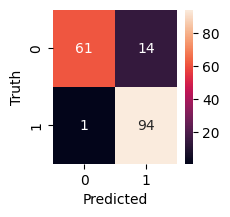

--------------------
Fold: 1
Metric --> Accuracy: 0.9058823529411765, Precision: 0.9087254901960785, Recall: 0.9058823529411765, F1: 0.903650313880493


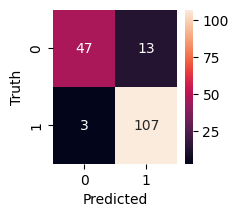

--------------------
Fold: 2
Metric --> Accuracy: 0.8705882352941177, Precision: 0.8702541025571933, Recall: 0.8705882352941177, F1: 0.8692546911237614


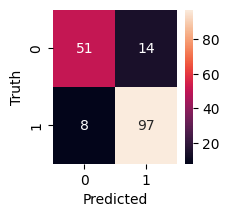

--------------------
Fold: 3
Metric --> Accuracy: 0.9117647058823529, Precision: 0.9160414165666265, Recall: 0.9117647058823529, F1: 0.9112928593897451


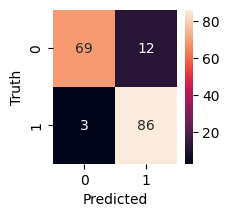

--------------------
Fold: 4
Metric --> Accuracy: 0.9117647058823529, Precision: 0.9148930481283423, Recall: 0.9117647058823529, F1: 0.9105685258783334


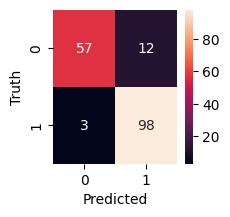

In [12]:
model = MultinomialNB()
kf = KFold(n_splits=5, random_state=MYRANDOMSTATE, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kf.split(x_train, y_train)):
    print("--------------------")
    print(f"Fold: {fold}")
    x_train, x_val = x[train_idx], x[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='weighted')
    rec = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    print(f"Metric --> Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1: {f1}")
    
    #plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(2,2))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

    # save model
    savename = f"model_fold{fold}.sav"
    savepath = f"model/{savename}"
    pickle.dump(model, open(savepath, 'wb'))

# 3. Tahap Testing
##### 3.1 Melakukan testing dengan menggunakan data test

Hasil Testing --> Accuracy: 0.8866666666666667, Precision: 0.9039517345399698, Recall: 0.8866666666666667, F1: 0.8862884686688914


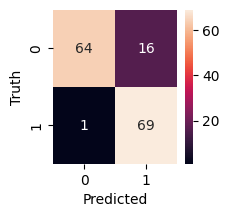

In [13]:
selected_model_name = "model_fold0.sav" # <-- Pilih model yang diinginkan
selected_model_path = f"model/{selected_model_name}"
selected_model = pickle.load(open(selected_model_path, 'rb'))

# do the testing
y_pred = selected_model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Hasil Testing --> Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1: {f1}")

# draw confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

##### 3.2 Menguji inferensi dengan kata-kata sendiri

In [14]:
def predict_sentiment(text):
    text = textclean(text)
    text = word_tokenize(text)
    text = [kamus_perb_kata.get(i, i) for i in text]
    text = [item for item in text if item not in stopwords]
    text = [stemmer.stem(item) for item in text]
    text = ' '.join(text)
    text = vectorizer.transform([text])
    text = transformer.transform(text)
    text = selected_model.predict(text)

    if text == 1:
        print("Sentimen Positif")
    elif text == 0:
        print("Sentimen Negatif")

In [18]:
predict_sentiment("Keren banget, mantap") # True Positive
predict_sentiment("Ujung-ujungnya proyek lagi dan duit lagi") # True Negative
predict_sentiment("Program yang buat gw jd lama lulus dan nyusahin") # True Negative
predict_sentiment("Hadeh, Siap-siap lembur bagai kuda dengan tugas seabrek") # False Positive
predict_sentiment("Terobosan modern buat bangsa ini") # True Positive
predict_sentiment("Kerjaan yang bikin gw jadi stress") # False Positive
predict_sentiment("Program ini mengurangi mental-mental budak di indonesia") # False Negative

Sentimen Positif
Sentimen Negatif
Sentimen Negatif
Sentimen Positif
Sentimen Positif
Sentimen Positif
Sentimen Negatif
